In [1]:
%matplotlib notebook

from rlsm.datasets import load_consulting
from rlsm import ReciprocityLSM

In [2]:
import networkx as nx
import pandas as pd

data = pd.read_table('consulting3.txt', header=None, sep=' ').loc[:, 1:]
data.columns = ['a', 'b', 'weight']

In [3]:
g = nx.from_pandas_edgelist(data, source='a', target='b', edge_attr='weight', 
                            create_using=nx.DiGraph)

In [4]:
Y = nx.to_numpy_array(g, weight='weight')
Y = (Y >= 3).astype(int)

In [2]:
Y = load_consulting()

In [4]:
model = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=42)
model.sample(Y, n_warmup=5000, n_samples=5000)

sample: 100%|███████████████████████████████████████████████████████████████| 10000/10000 [02:15<00:00, 73.84it/s, 127 steps of size 4.48e-02. acc. prob=0.80]


In [5]:
model.print_summary()

AUC: 0.970, WAIC: 2395.549

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     a_sigma      2.30      0.51      2.25      1.51      3.11   1092.77      1.00
    ab_sigma     -0.18      0.22     -0.18     -0.53      0.17   1427.53      1.00
     b_sigma      0.68      0.19      0.66      0.38      0.95   1506.35      1.00
   dist_coef      0.43      0.08      0.43      0.31      0.56   2683.44      1.00
  recip_coef      0.48      0.36      0.48     -0.12      1.04   2401.54      1.00
     u_sigma      3.90      0.31      3.89      3.39      4.40   1485.04      1.00

Number of divergences: 118


<IPython.core.display.Javascript object>


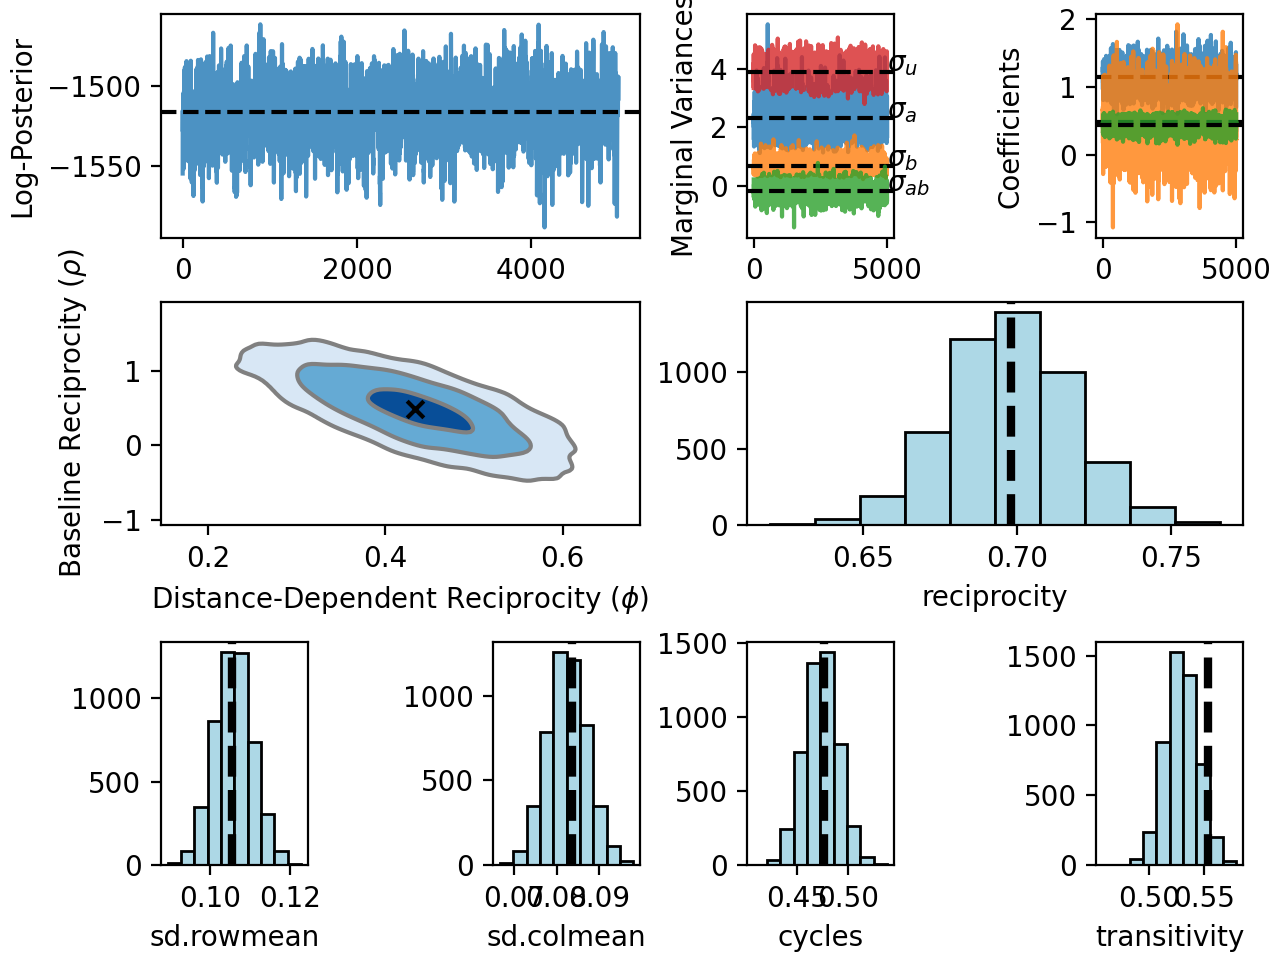

In [6]:
model.plot();

<IPython.core.display.Javascript object>


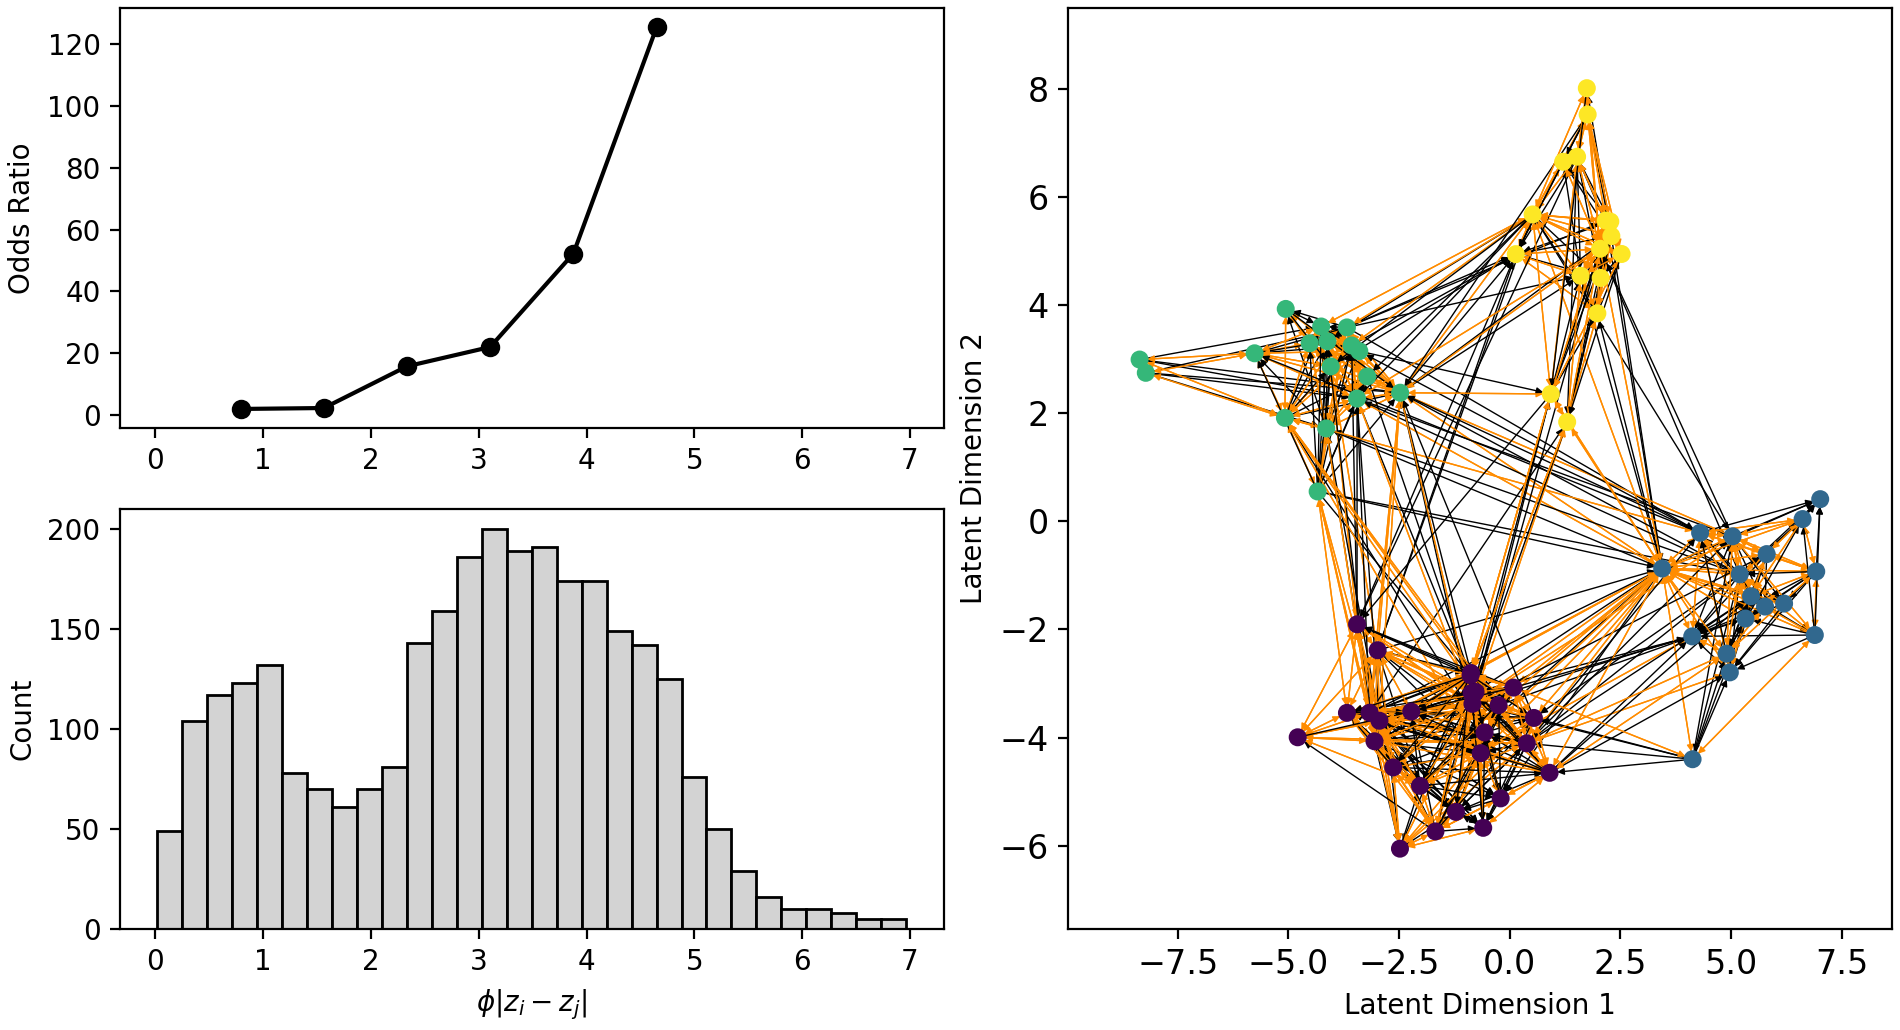

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_82166/2516769537.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.U_))


In [8]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.U_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
qs = np.linspace(d.min(), d.max(), 10)
#qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i], d <= qs[i+1]))[0]])
    tots = a.sum(axis=0) 
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if tots[1] * tots[2] > 0:
        res.append(gamma)
        dist.append(qs[i+1])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')#.histplot(d, axes=ax[0])
ax['A'].plot(np.asarray(dist), res, 'ko-')
#ax[0].axvline(model.recip_coef_, linestyle=':', color='gray', lw=2)
ax['A'].set_ylabel('Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')

kmeans = KMeans(n_clusters=4).fit(model.U_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.U_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

## No Reciprocity

In [8]:
model_none = ReciprocityLSM(n_features=2, reciprocity_type='none', random_state=42)
model_none.sample(Y, n_warmup=5000, n_samples=5000)

sample: 100%|███████████| 10000/10000 [02:01<00:00, 82.19it/s, 127 steps of size 3.02e-02. acc. prob=0.86]


In [9]:
model_none.print_summary()

AUC: 0.972, WAIC: 2422.743

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   a_sigma      2.40      0.53      2.34      1.57      3.23   1155.90      1.00
  ab_sigma      0.97      0.31      0.94      0.49      1.44    917.50      1.00
   b_sigma      1.26      0.32      1.23      0.75      1.75    901.60      1.00
   u_sigma      4.48      0.31      4.47      3.99      5.01   1672.88      1.00

Number of divergences: 110


<IPython.core.display.Javascript object>


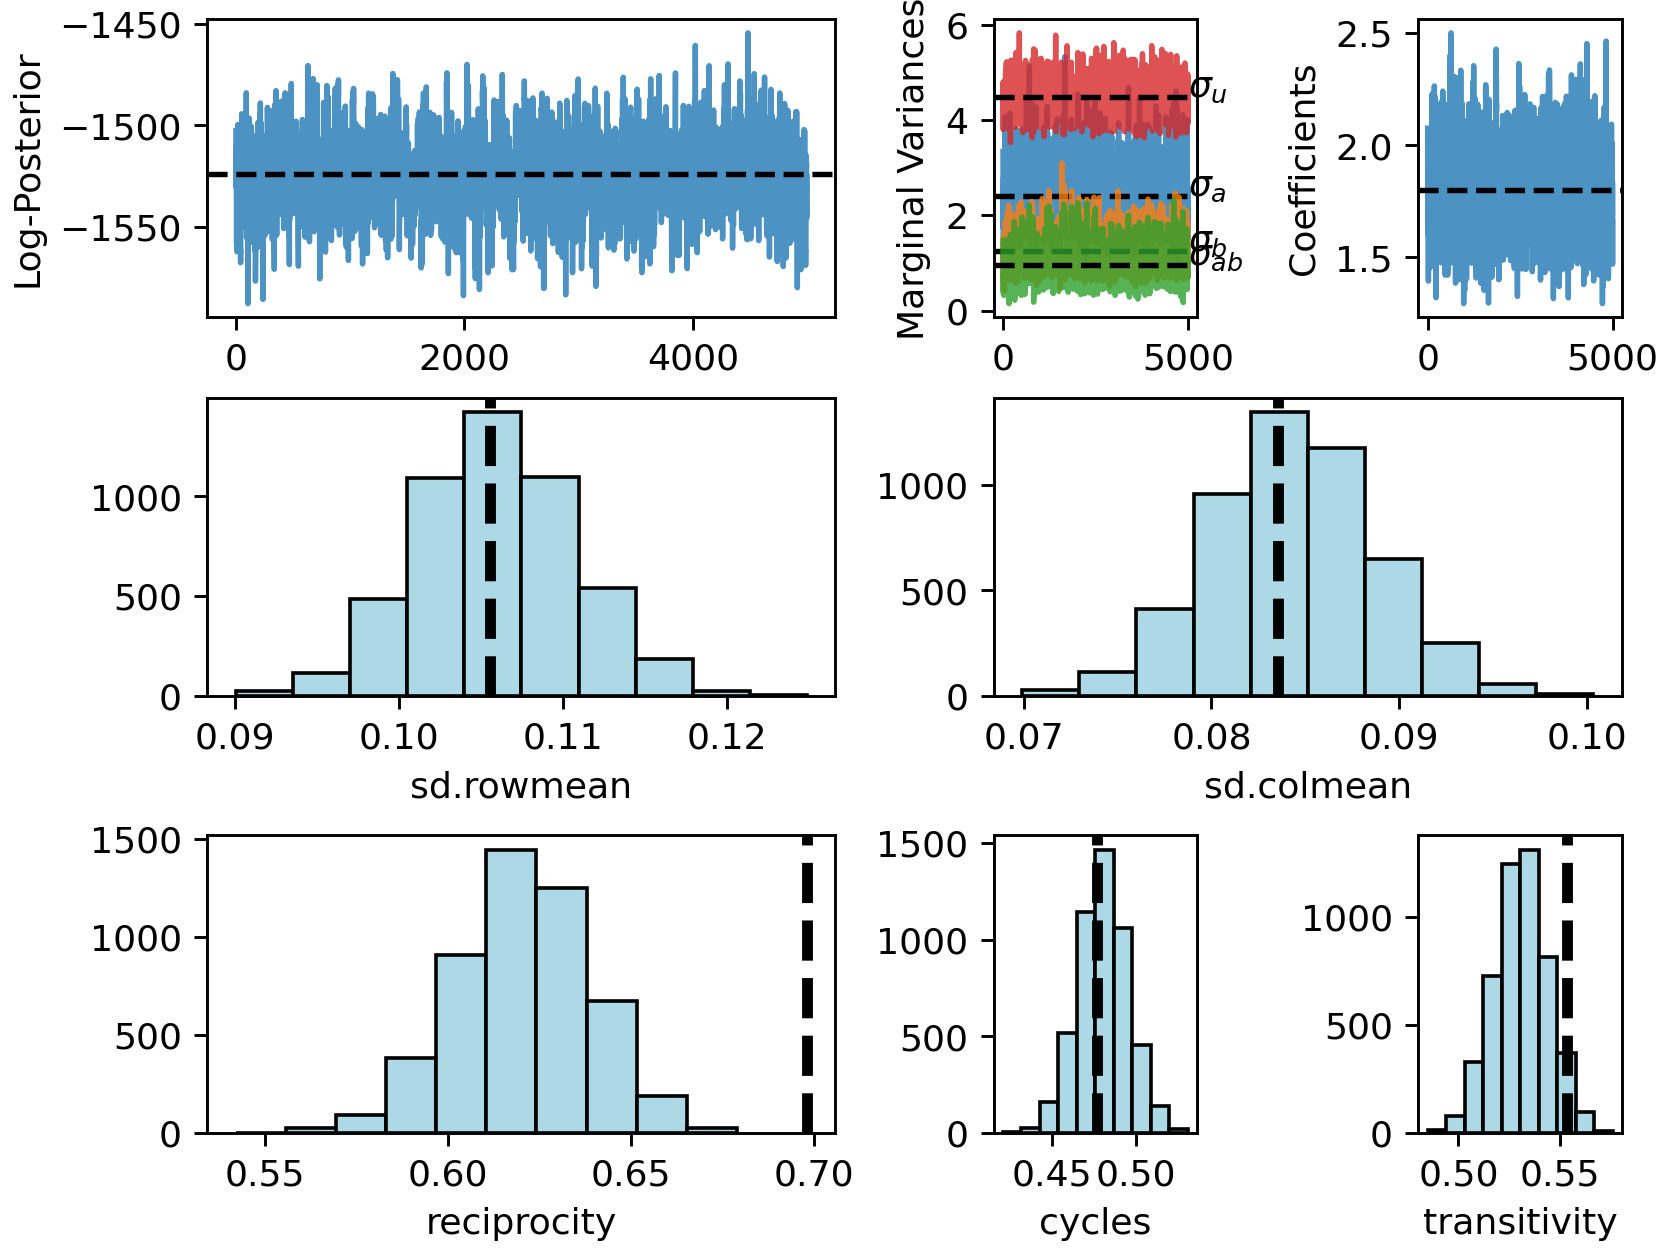

{'A': <Axes: label='A', ylabel='Log-Posterior'>,
 'B': <Axes: label='B', ylabel='Marginal Variances'>,
 'C': <Axes: label='C', ylabel='Coefficients'>,
 'D': <Axes: label='D', xlabel='sd.rowmean'>,
 'E': <Axes: label='E', xlabel='sd.colmean'>,
 'F': <Axes: label='F', xlabel='reciprocity'>,
 'G': <Axes: label='G', xlabel='cycles'>,
 'H': <Axes: label='H', xlabel='transitivity'>}

In [10]:
model_none.plot()